In [1]:
import tidy3d as td
import numpy as np
from matplotlib import pyplot as plt
from tidy3d import web

In [2]:
Si_n = 3.4777  # Si refraction index
Si_n_slope = 1.86e-4  # Si thermo-optic coefficient dn/dT, 1/K
Si_k = 148e-6  # Si thermal conductivity, W / (um * K)
Si_s = 0.71 * 2.33e-12  # Si volumetric heat capacity, J / (um^3 * K)

SiO2_n = 1.444  # SiO2 refraction index
SiO2_n_slope = 1e-5  # SiO2 thermo-optic coefficient dn/dT, 1/K
SiO2_k = 1.38e-6  # SiO2 thermal conductivity, W/(um*K)
SiO2_s = 0.709 * 2.203e-12  # SiO2 volumetric heat capacity, J / (um^3 * K)

SiN_n = 2.05
SiN_k = 3.2e-6  # W/um/C
SiN_s = 3.44e-12 * 0.71  # g/um^3 * J/gC

W_k = 173e-6  # W/um/K
W_s = 19.25e-12 * 0.134  # g/um^3 * J/gK
W_sigms = 17.9  # S/um

Cu_k = 401e-6  # W/(um⋅K)
Cu_s = 8.96e-12 * 0.385 # g/um^3 * J/gK
Cu_sigma = 59.6  # S/um

Al_k = 237e-6  # W/(um⋅K)
Al_s = 2.70e-12 * 0.89 # g/um^3 * J/gK
Al_sigma = 35  # S/um

In [3]:
Si_eps = Si_n**2
Si_eps_slope = 2 * Si_n * Si_n_slope

SiO2_eps = SiO2_n**2
SiO2_eps_slope = 2 * SiO2_n * SiO2_n_slope

In [4]:
Si = td.PerturbationMedium(
    permittivity=Si_eps,
    permittivity_perturbation=td.ParameterPerturbation(
        heat=td.LinearHeatPerturbation(coeff=Si_eps_slope, temperature_ref=300)
    ),
    heat_spec=td.SolidSpec(
        conductivity=Si_k,
        capacity=Si_s,
    ),
    name="Si",
)

SiO2 = td.PerturbationMedium(
    permittivity=SiO2_eps,
    permittivity_perturbation=td.ParameterPerturbation(
        heat=td.LinearHeatPerturbation(coeff=SiO2_eps_slope, temperature_ref=300)
    ),
    heat_spec=td.SolidSpec(
        conductivity=SiO2_k,
        capacity=SiO2_s,
    ),
    name="SiO2",
)

SiN = td.material_library["SiN"]["Horiba"].updated_copy(heat_spec=td.SolidSpec(conductivity=SiN_k, capacity=SiN_s), name="SiN")
W = td.material_library["W"]["Werner2009"].updated_copy(heat_spec=td.SolidSpec(conductivity=W_k, capacity=W_s), name="W")
Cu = td.material_library["Cu"]["JohnsonChristy1972"].updated_copy(heat_spec=td.SolidSpec(conductivity=Cu_k, capacity=Cu_s), name="Cu")
Al = td.material_library["Al"]["Rakic1995"].updated_copy(heat_spec=td.SolidSpec(conductivity=Al_k, capacity=Al_s), name="Al")
air = td.Medium(heat_spec=td.FluidSpec(), name="air")

In [6]:
sim = td.Simulation.from_file("sim_orig.hdf5")

15:20:09 CST WARNING: updating Simulation from 2.5 to 2.6                       

In [7]:
med_mapping = {SiN: [0], Si: [1, 2, 3], W: [4], Cu: [5, 6, 7, 8, 9, 10, 13, 14], Al: [11, 12, 15, 16]}

In [8]:
mediums = list(np.zeros(len(sim.structures)))

In [9]:
for med, inds in med_mapping.items():
    for ind in inds:
        mediums[ind] = med

In [10]:
new_structures = []

for ind, (s, med) in enumerate(zip(sim.structures, mediums)):
    new_structures.append(s.updated_copy(medium=med, name=f"s{ind}"))
    

In [11]:
bottom = td.Structure(
    geometry=td.Box(center=(0, 0, sim.bounds[0][2]), size=(td.inf, td.inf, 0.5)), 
    medium=air,
    name="bottom",
)
top = td.Structure(
    geometry=td.Box(center=(0, 0, sim.bounds[1][2]), size=(td.inf, td.inf, 2)), 
    medium=air,
    name="top",
)
new_structures += [bottom, top]

                

In [12]:
scene = td.Scene(structures=new_structures, medium=SiO2)

<Axes: title={'center': 'cross section at y=0.00'}, xlabel='x', ylabel='z'>

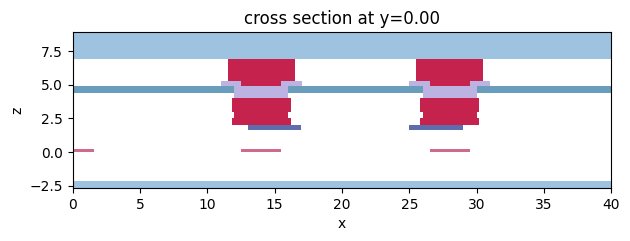

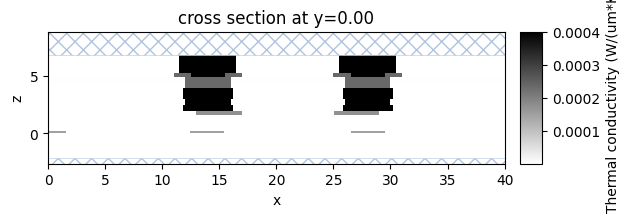

In [13]:
scene.plot(y=0, hlim=[0, 40])
scene.plot_heat_conductivity(y=0, hlim=[0, 40])

In [14]:
temp_3d = td.TemperatureMonitor(center=sim.center, size=(sim.size[0]*1.2, sim.size[1]*1.2, sim.size[2]), name="3d")
temp_heater = td.TemperatureMonitor(
    center=(0, 0, sim.structures[4].geometry.bounding_box.center[2]), 
    size=(td.inf, td.inf, 0), 
    unstructured=True, 
    conformal=True, 
    name="heater",
)
temp_wg = td.TemperatureMonitor(
    center=(0, 0, sim.structures[1].geometry.bounding_box.center[2]), size=(td.inf, td.inf, 0), unstructured=True, conformal=True, name="wg"
)
temp_center = td.TemperatureMonitor(
    center=(sim.structures[4].geometry.bounding_box.center[0]+1e-5, 0, 0), size=(0, td.inf, td.inf), unstructured=True, name="center"
)
temp_via = td.TemperatureMonitor(
    center=(sim.structures[6].geometry.bounding_box.center[0], 0, 0), size=(0, td.inf, td.inf), unstructured=True, conformal=True, name="via"
)

In [15]:
heat_source = td.UniformHeatSource(rate=2e-3, structures=["s4"])

In [16]:
bc_bottom = td.HeatBoundarySpec(condition=td.TemperatureBC(temperature=300), placement=td.StructureBoundary(structure="bottom"))
# bc_ = td.HeatBoundarySpec(condition=td.TemperatureBC(temperature=300), placement=td.StructureBoundary(structure="bottom"))

In [17]:
grid_spec = td.DistanceUnstructuredGrid(
    dl_interface=0.1, 
    dl_bulk=1, 
    distance_interface=0.1, 
    distance_bulk=1, 
    non_refined_structures=["s0", "bottom", "top"],
)

In [18]:
heat_sim = td.HeatSimulation(
    structures=new_structures,
    symmetry=(1, 0, 0),
    medium=SiO2,
    center=sim.center, 
    size=(sim.size[0]*1.2, sim.size[1]*1.2, sim.size[2]),
    sources=[heat_source],
    monitors=[temp_3d, temp_heater, temp_wg, temp_center, temp_via],
    boundary_spec=[bc_bottom],
    grid_spec=grid_spec,
)
    

<Axes: title={'center': 'cross section at y=0.10'}, xlabel='x', ylabel='z'>

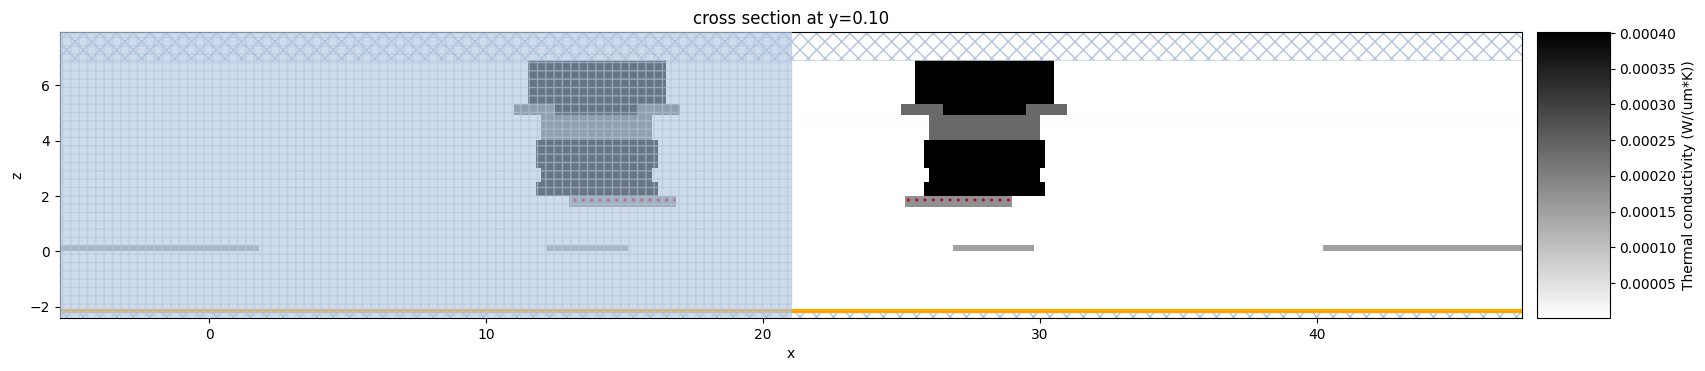

In [19]:
_, ax = plt.subplots(1, 1, figsize=(20, 5))
# heat_sim.plot(y=0.1, ax=ax, monitor_alpha=0)
heat_sim.plot_heat_conductivity(y=0.1, ax=ax, monitor_alpha=0)

In [20]:
from tidy3d.web import run

In [21]:
heat_sim_data = run(heat_sim, task_name="lucas_heat", solver_version="heat-solver-0.0.0")

15:21:46 CST Created task 'lucas_heat' with task_id                             
             'he-f18e9bf5-1d62-4e4a-994d-77e50d5b6891' and task_type 'HEAT'.

             Tidy3D's heat solver is currently in the beta stage. All heat      
             simulations are charged a flat fee of 0.025 FlexCredit.

Output()

15:21:48 CST Heat solver status: queued

15:21:59 CST Heat solver status: preprocess

15:22:51 CST Heat solver status: running

15:22:57 CST Heat solver status: postprocess

15:23:19 CST Heat solver status: success

Output()

15:23:26 CST loading simulation from simulation_data.hdf5

<Axes: title={'center': 'cross section at x=21.00'}, xlabel='y', ylabel='z'>

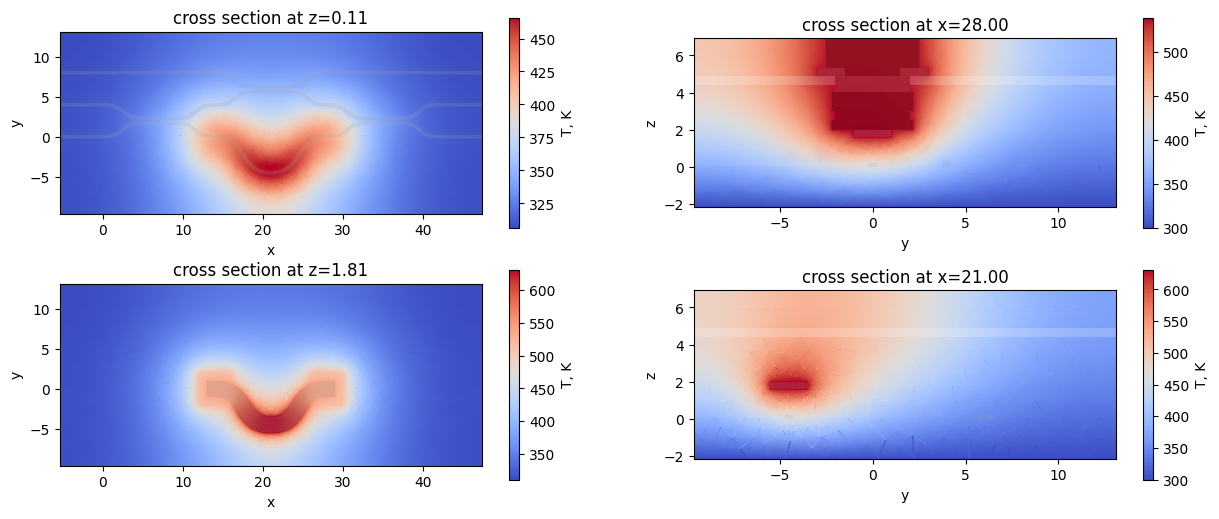

In [22]:
_, ax = plt.subplots(2, 2, figsize=(15, 6))
heat_sim_data.plot_field("wg", ax=ax[0, 0])
heat_sim_data.plot_field("heater", ax=ax[1, 0])
heat_sim_data.plot_field("via", ax=ax[0, 1])
heat_sim_data.plot_field("center", ax=ax[1, 1])
# heat_sim_data["3d"].temperature.sel(z=0.1, method="nearest").plot(x="x")

In [24]:
# 0 SiO2_Horiba background
# 1 SiN_Horiba top 0
# 2 cSi_Li1993_293K waveguides 1, 2, 3
# 3 W_Werner2009 heater 4
# 4 Cu_JohnsonChristy1972 connectors 5, 6, 7, 8, 9, 10, 13, 14
# 5 Al_Rakic1995 pads 11, 12, 15, 16
# 6 ??? contacts 13, 14


In [23]:
new_sim = sim.updated_copy(structures=new_structures, medium=SiO2)

In [24]:
red_sim = new_sim.subsection(region=td.Box.from_bounds((-td.inf, -td.inf, -1.4), (td.inf, td.inf, 1.6)))

<Axes: title={'center': 'cross section at z=0.00'}, xlabel='x', ylabel='y'>

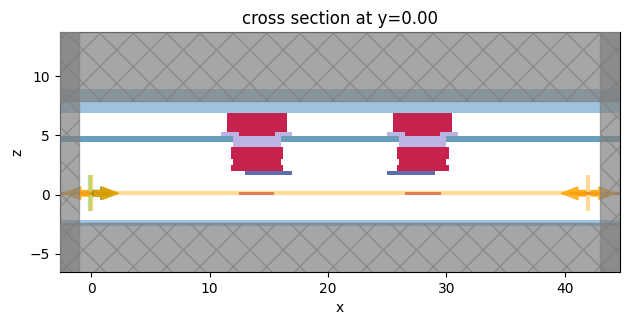

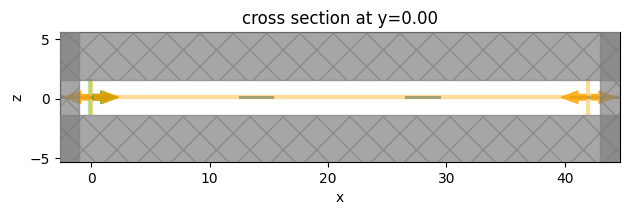

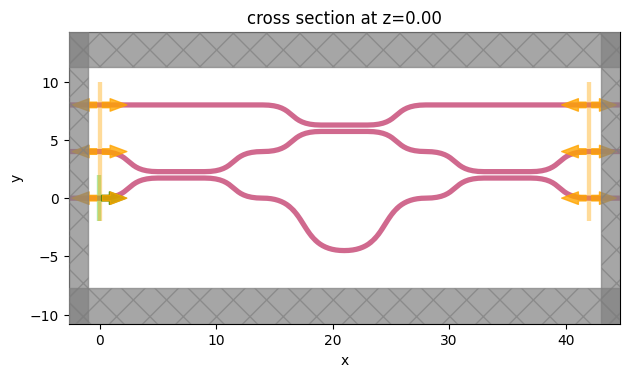

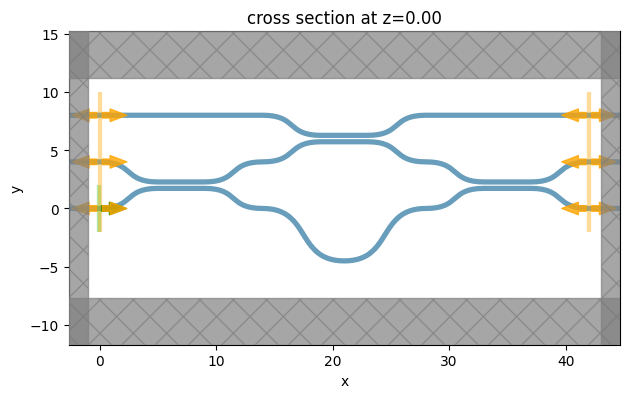

In [25]:
new_sim.plot(y=0)
red_sim.plot(y=0)
new_sim.plot(z=0)
red_sim.plot(z=0)

In [26]:
per_sim = red_sim.perturbed_mediums_copy(temperature=heat_sim_data["3d"].temperature)

15:24:52 CST WARNING: Provided 'temperature' does not fully cover simulation    
             domain.                                                            

<Axes: title={'center': 'cross section at z=0.00'}, xlabel='x', ylabel='y'>

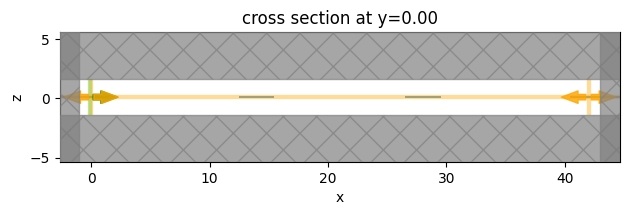

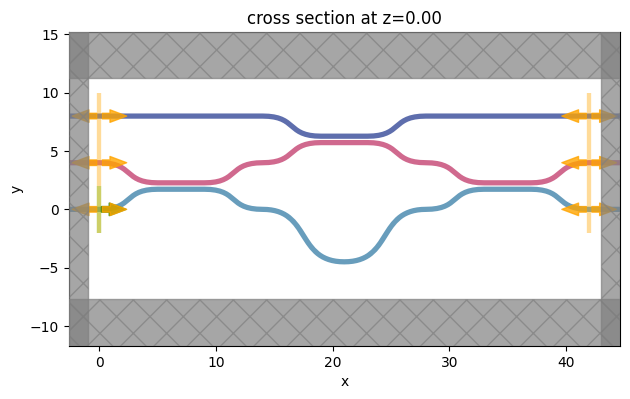

In [27]:
per_sim.plot(y=0)
per_sim.plot(z=0)

In [30]:
per_sim.to_file('per_sim.hdf5')

In [28]:
per_sim_data = web.run(per_sim, task_name="perturbed_lucas")

15:25:16 CST Created task 'perturbed_lucas' with task_id                        
             'fdve-179165d1-ccce-4c85-b3c5-67d55d052a88' and task_type 'FDTD'.

15:25:17 CST View task using web UI at                                          
             ]8;id=829511;https://tidy3d.simulation.cloud/workbench?taskId=fdve-179165d1-ccce-4c85-b3c5-67d55d052a88\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=802939;https://tidy3d.simulation.cloud/workbench?taskId=fdve-179165d1-ccce-4c85-b3c5-67d55d052a88\taskId]8;;\]8;id=829511;https://tidy3d.simulation.cloud/workbench?taskId=fdve-179165d1-ccce-4c85-b3c5-67d55d052a88\=]8;;\]8;id=774422;https://tidy3d.simulation.cloud/workbench?taskId=fdve-179165d1-ccce-4c85-b3c5-67d55d052a88\fdve]8;;\]8;id=829511;https://tidy3d.simulation.cloud/workbench?taskId=fdve-179165d1-ccce-4c85-b3c5-67d55d052a88\-179165d1-ccc]8;;\
             ]8;id=829511;https://tidy3d.simulation.cloud/workbench?taskId=fdve-179165d1-ccce-4c85-b3c5-67d55d052a88\e-4c85-b3c5-67d55d052a88']8;;\.

Output()

15:26:25 CST status = queued

Output()

15:27:15 CST status = preprocess

15:27:22 CST Maximum FlexCredit cost: 3.966. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

15:27:23 CST running solver

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

15:30:11 CST early shutoff detected at 12%, exiting.

             status = postprocess

Output()

15:31:26 CST status = success

15:31:27 CST View simulation result at                                          
             ]8;id=620921;https://tidy3d.simulation.cloud/workbench?taskId=fdve-179165d1-ccce-4c85-b3c5-67d55d052a88\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=58815;https://tidy3d.simulation.cloud/workbench?taskId=fdve-179165d1-ccce-4c85-b3c5-67d55d052a88\taskId]8;;\]8;id=620921;https://tidy3d.simulation.cloud/workbench?taskId=fdve-179165d1-ccce-4c85-b3c5-67d55d052a88\=]8;;\]8;id=189526;https://tidy3d.simulation.cloud/workbench?taskId=fdve-179165d1-ccce-4c85-b3c5-67d55d052a88\fdve]8;;\]8;id=620921;https://tidy3d.simulation.cloud/workbench?taskId=fdve-179165d1-ccce-4c85-b3c5-67d55d052a88\-179165d1-ccc]8;;\
             ]8;id=620921;https://tidy3d.simulation.cloud/workbench?taskId=fdve-179165d1-ccce-4c85-b3c5-67d55d052a88\e-4c85-b3c5-67d55d052a88']8;;\.

Output()

15:31:45 CST loading simulation from simulation_data.hdf5

In [29]:
red_sim_data = web.run(red_sim, task_name="unperturbed_lucas")

15:43:11 CST Created task 'unperturbed_lucas' with task_id                      
             'fdve-7bc77531-afe4-47da-a26c-4ea5e6834d5a' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=513037;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7bc77531-afe4-47da-a26c-4ea5e6834d5a\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=836770;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7bc77531-afe4-47da-a26c-4ea5e6834d5a\taskId]8;;\]8;id=513037;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7bc77531-afe4-47da-a26c-4ea5e6834d5a\=]8;;\]8;id=377838;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7bc77531-afe4-47da-a26c-4ea5e6834d5a\fdve]8;;\]8;id=513037;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7bc77531-afe4-47da-a26c-4ea5e6834d5a\-7bc77531-afe]8;;\
             ]8;id=513037;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7bc77531-afe4-47da-a26c-4ea5e6834d5a\4-47da-a26c-4ea5e6834d5a']8;;\.

Output()

15:43:13 CST status = queued

Output()

16:43:45 CST status = preprocess

16:43:50 CST Maximum FlexCredit cost: 3.907. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

16:45:49 CST early shutoff detected at 12%, exiting.

             status = postprocess

Output()

16:45:57 CST status = success

             View simulation result at                                          
             ]8;id=673687;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7bc77531-afe4-47da-a26c-4ea5e6834d5a\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=975103;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7bc77531-afe4-47da-a26c-4ea5e6834d5a\taskId]8;;\]8;id=673687;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7bc77531-afe4-47da-a26c-4ea5e6834d5a\=]8;;\]8;id=585444;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7bc77531-afe4-47da-a26c-4ea5e6834d5a\fdve]8;;\]8;id=673687;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7bc77531-afe4-47da-a26c-4ea5e6834d5a\-7bc77531-afe]8;;\
             ]8;id=673687;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7bc77531-afe4-47da-a26c-4ea5e6834d5a\4-47da-a26c-4ea5e6834d5a']8;;\.

Output()

16:46:11 CST loading simulation from simulation_data.hdf5

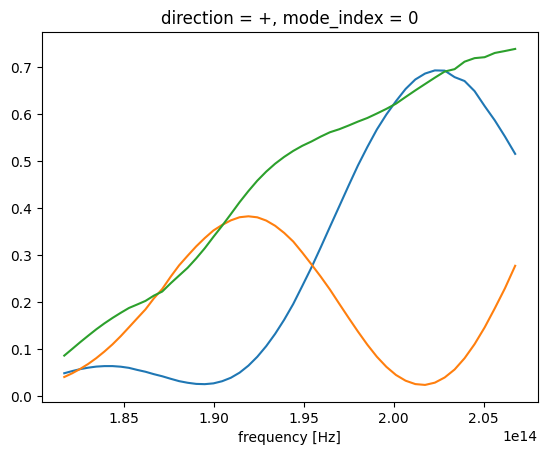

In [30]:

(red_sim_data["P3"].amps**2).abs.sel(direction="+").plot()
(red_sim_data["P4"].amps**2).abs.sel(direction="+").plot()
(red_sim_data["P3"].amps**2 + red_sim_data["P4"].amps**2).abs.sel(direction="+").plot()

Text(0.5, 1.0, 'top')

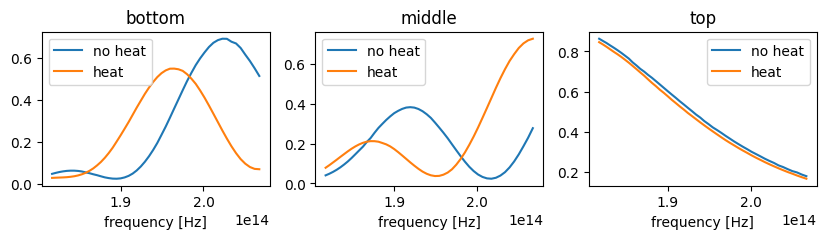

In [31]:
# sim_data["P0"].amps.abs.sel(direction="+").plot()
# sim_data["P1"].amps.abs.sel(direction="+").plot()
# sim_data["P2"].amps.abs.sel(direction="+").plot()
_, ax = plt.subplots(1, 3, figsize=(10, 2))
(red_sim_data["P3"].amps**2).abs.sel(direction="+").plot(ax=ax[0])
(per_sim_data["P3"].amps**2).abs.sel(direction="+").plot(ax=ax[0])
ax[0].legend(["no heat", "heat"])
ax[0].set_title("bottom")

(red_sim_data["P4"].amps**2).abs.sel(direction="+").plot(ax=ax[1])
(per_sim_data["P4"].amps**2).abs.sel(direction="+").plot(ax=ax[1])
ax[1].legend(["no heat", "heat"])
ax[1].set_title("middle")

(red_sim_data["P5"].amps**2).abs.sel(direction="+").plot(ax=ax[2])
(per_sim_data["P5"].amps**2).abs.sel(direction="+").plot(ax=ax[2])
ax[2].legend(["no heat", "heat"])
ax[2].set_title("top")
# plt.legend(["0", "1", "2", "3", "4", "5"])
# plt.legend(["3", "4", "5"])

Text(0.5, 1.0, 'heat')

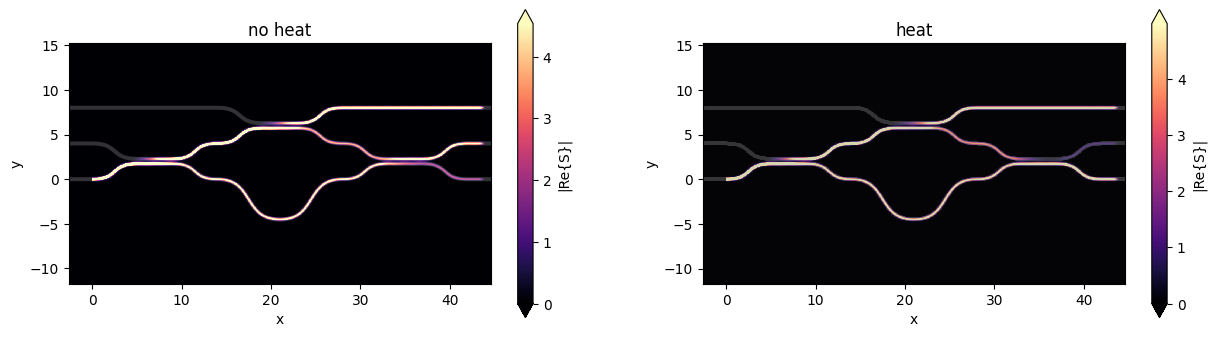

In [32]:
_, ax = plt.subplots(1, 2, figsize=(15, 4))
red_sim_data.plot_field('field', 'S', ax=ax[0])
per_sim_data.plot_field('field', 'S', ax=ax[1])
ax[0].set_title("no heat")
ax[1].set_title("heat")